    Best Time to visit                              Best Months
0  Throughout the year  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
1     October to March                    [1, 2, 3, 10, 11, 12]
2      October to June           [1, 2, 3, 4, 5, 6, 10, 11, 12]
3     October to March                    [1, 2, 3, 10, 11, 12]
4       October to Jun           [1, 2, 3, 4, 5, 6, 10, 11, 12]
5      October to June           [1, 2, 3, 4, 5, 6, 10, 11, 12]
6     October to March                    [1, 2, 3, 10, 11, 12]
7        June to March        [1, 2, 3, 6, 7, 8, 9, 10, 11, 12]
8     April to October                   [4, 5, 6, 7, 8, 9, 10]
9     October to March                    [1, 2, 3, 10, 11, 12]

Model Performance Metrics:
Accuracy: Naïve Bayes = 0.8333, Decision Tree = 0.6667
Precision: Naïve Bayes = 0.8438, Decision Tree = 0.7193
Recall: Naïve Bayes = 0.8333, Decision Tree = 0.6667
F1 Score: Naïve Bayes = 0.8321, Decision Tree = 0.6442


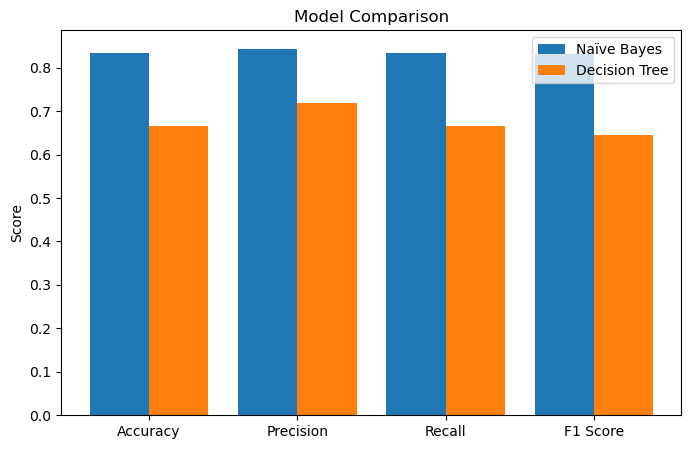

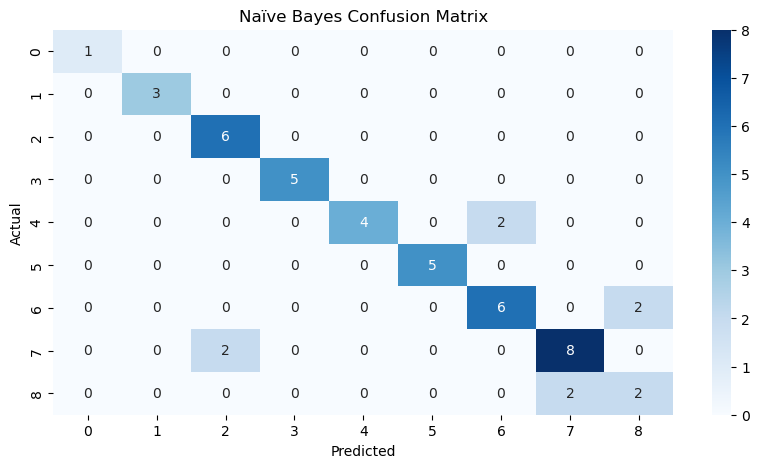

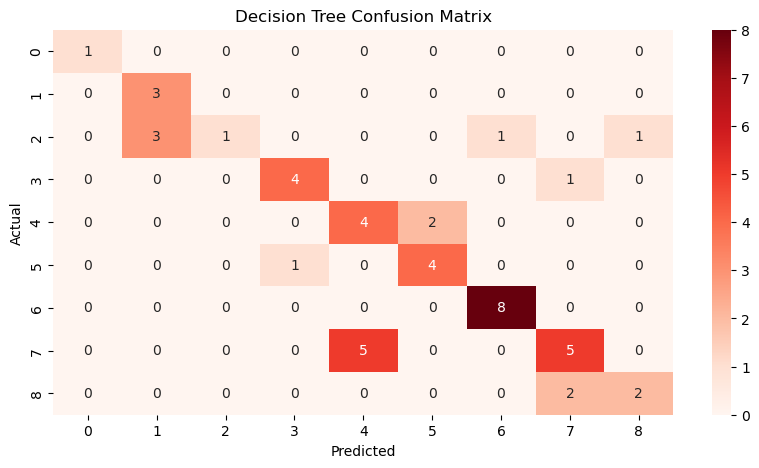


Naïve Bayes Recommendations:
            City  Rating Best Time to visit
7     Alleppey       4.8      June to March
5       Manali       4.8    October to June
31   Mussoorie       4.8  September to June
27      Shimla       4.8    October to June
121     Manali       4.8    October to June

Decision Tree Recommendations:
            City  Rating Best Time to visit
7     Alleppey       4.8      June to March
5       Manali       4.8    October to June
31   Mussoorie       4.8  September to June
27      Shimla       4.8    October to June
121     Manali       4.8    October to June


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)

def preprocess_data(df):
    descriptions = df["About the city (long Description)"].fillna("")
    df["Rating"] = pd.to_numeric(df["Rating"], errors='coerce')
    df["Rating"] = df["Rating"].fillna(df["Rating"].median())

    # Define month mapping
    month_map = {
        "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
        "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12,
        "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, 
        "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
    }
    
    def extract_months(time_str):
        if pd.isna(time_str) or "throughout the year" in time_str.lower():
            return list(range(1, 13))  # All 12 months

        months = []
        words = time_str.split()
        for i, word in enumerate(words):
            if word in month_map:
                if i + 1 < len(words) and words[i + 1] == "to":  # Range case
                    if i + 2 < len(words) and words[i + 2] in month_map:
                        start, end = month_map[word], month_map[words[i + 2]]
                        if start <= end:
                            months.extend(range(start, end + 1))
                        else:  # Handle year wrapping (e.g., Oct to Mar -> [10,11,12,1,2,3])
                            months.extend(list(range(start, 13)) + list(range(1, end + 1)))
                else:
                    months.append(month_map[word])  # Single month case
        return sorted(set(months))  # Remove duplicates & sort

    df["Best Months"] = df["Best Time to visit"].apply(extract_months)

    return descriptions, df["Rating"], df


def train_models(descriptions, ratings):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(ratings)
    X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2, random_state=42)
    
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
    
    nb_model = make_pipeline(tfidf, MultinomialNB(alpha=0.1))
    nb_model.fit(X_train, y_train)
    y_pred_nb = nb_model.predict(X_test)
    
    dt_model = make_pipeline(tfidf, DecisionTreeClassifier(max_depth=15, min_samples_split=5, criterion='entropy'))
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)
    
    metrics = {
        "Accuracy": [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_dt)],
        "Precision": [precision_score(y_test, y_pred_nb, average='weighted', zero_division=0),
                      precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)],
        "Recall": [recall_score(y_test, y_pred_nb, average='weighted', zero_division=0),
                   recall_score(y_test, y_pred_dt, average='weighted', zero_division=0)],
        "F1 Score": [f1_score(y_test, y_pred_nb, average='weighted', zero_division=0),
                     f1_score(y_test, y_pred_dt, average='weighted', zero_division=0)]
    }
    
    print("\nModel Performance Metrics:")
    for metric, values in metrics.items():
        print(f"{metric}: Naïve Bayes = {values[0]:.4f}, Decision Tree = {values[1]:.4f}")
    
    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics))
    plt.bar(x - 0.2, [metrics[m][0] for m in metrics], 0.4, label="Naïve Bayes")
    plt.bar(x + 0.2, [metrics[m][1] for m in metrics], 0.4, label="Decision Tree")
    plt.xticks(x, metrics.keys())
    plt.ylabel("Score")
    plt.title("Model Comparison")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt="d", cmap="Blues")
    plt.title("Naïve Bayes Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", cmap="Reds")
    plt.title("Decision Tree Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return nb_model, dt_model, label_encoder

def recommend_cities(nb_model, dt_model, label_encoder, df):
    try:
        num_descriptions = int(input("Enter the number of descriptions (1-3): ").strip() or 1)
        num_descriptions = max(1, min(3, num_descriptions))
    except ValueError:
        num_descriptions = 1
    
    descriptions = [input(f"Enter description {i+1}: ").strip() for i in range(num_descriptions)]
    input_text = " ".join(descriptions)
    
    try:
        month = int(input("Enter the preferred month (1-12): ").strip() or 0)
    except ValueError:
        month = 0

    # Predict probabilities for description input
    nb_pred = nb_model.predict_proba([input_text])
    dt_pred = dt_model.predict_proba([input_text])

    # Get top predictions
    nb_top_indices = np.argsort(nb_pred[0])[-10:][::-1]
    dt_top_indices = np.argsort(dt_pred[0])[-10:][::-1]
    
    predicted_ratings_nb = label_encoder.inverse_transform(nb_top_indices)
    predicted_ratings_dt = label_encoder.inverse_transform(dt_top_indices)

    # Filter the dataframe based on predicted ratings and preferred month
    def filter_recommendations(predicted_ratings):
        recommendations = df[df["Rating"].isin(predicted_ratings)].copy()
        if month in range(1, 13):
            recommendations = recommendations[recommendations["Best Months"].apply(lambda x: month in x)]
        # Sort by rating (descending) and get top 5
        return recommendations.sort_values(by="Rating", ascending=False).head(5)

    recommended_cities_nb = filter_recommendations(predicted_ratings_nb)
    recommended_cities_dt = filter_recommendations(predicted_ratings_dt)
    
    print("\nNaïve Bayes Recommendations:")
    if not recommended_cities_nb.empty:
        print(recommended_cities_nb[["City", "Rating", "Best Time to visit"]])
    else:
        print("No matching cities found.")

    print("\nDecision Tree Recommendations:")
    if not recommended_cities_dt.empty:
        print(recommended_cities_dt[["City", "Rating", "Best Time to visit"]])
    else:
        print("No matching cities found.")

df = pd.read_csv("holidify.csv")
descriptions, ratings, df = preprocess_data(df)
print(df[["Best Time to visit", "Best Months"]].head(10))
nb_model, dt_model, label_encoder = train_models(descriptions, ratings)